# Glia.ConversationAI.NLP.TextClassifier
## Aliasgher Dalal
## 2023-11-20

The project is done as a take home assignment from Glia Inc. given as part of the assessment for the role of Data Scientist: Conversational AI

## Libraries

In [1]:
import pandas as pd
import numpy as np
import csv
import os
import re

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import learning_curve    

ngram_range = (1, 1)  # using change for different n-grams
cVectorize = CountVectorizer(ngram_range=ngram_range)

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import collections
from collections import defaultdict

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.python import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding,LSTM,Embedding,SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import utils as np_utils

from tkinter import *
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
import scipy
import pickle


modelPath = "/Users/aliasgherdalal/Documents/Glia/models/"
datasetPath = "/Users/aliasgherdalal/Documents/Glia/dataset/"


/Users/aliasgherdalal/anaconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Business Understanding & Requirements

The business goal is to develop an application that can categorize a medical abstract into one of the five conditions. Each class represent current medical condition of a patient. These conditions are:  
These classes 
    1	neoplasms
	2	digestive system diseases
	3	nervous system diseases
	4	cardiovascular diseases
	5	general pathological conditions
To aid in the development of the application, dataset containing ~28k labelled abstracts is provided. 

Initial analysis shows that a text classification machine learning technique may be applied to develop an application, which when given an abstract will be capable of returning the most likely condition that the medical abstract is referring to in the text and hence the patient associated to the abstract is currently afflicted to.

## Data Understanding & Processing

This section of the notebook processes data, analyses and prepares data for the next stage of classification i.e. machine learning modelling.

Data is ingested - in this case Kaggle dataset for medical abstracts is ingested. The data is then processed through various claeaning stages including removal of missing data. In addition, the abstract text is converted to lower case, and split into word tokens. The stopwords are then removed from the text and lemmatization is performed before putting the processed word tokens back into string. The string represent processed medical abstract ready for further processing.

Finally, the processed text is vectorized for input into the machine learnign model(s).



### Data Ingestion
#### Source: https://www.kaggle.com/datasets/chaitanyakck/medical-text/

In [2]:
#Ingest data from csv into pandas dataframe
data_folder = "/Users/aliasgherdalal/Documents/Glia/dataset"
fLabel = datasetPath + "medical_tc_labels.csv"
fTrain = datasetPath + "medical_tc_train.csv"
fTest  = datasetPath + "medical_tc_test.csv"

dfLabel=pd.read_csv(fLabel)
dfTrain=pd.read_csv(fTrain)
dfTest=pd.read_csv(fTest)


In [3]:
print(dfLabel.head(),'\n',dfLabel.shape)

   condition_label                   condition_name
0                1                        neoplasms
1                2        digestive system diseases
2                3          nervous system diseases
3                4          cardiovascular diseases
4                5  general pathological conditions 
 (5, 2)


   condition_label                                   medical_abstract
0                5  Tissue changes around loose prostheses. A cani...
1                1  Neuropeptide Y and neuron-specific enolase lev...
2                2  Sexually transmitted diseases of the colon, re...
3                1  Lipolytic factors associated with murine and h...
4                3  Does carotid restenosis predict an increased r... 
 (11550, 2)


<Axes: xlabel='condition_label'>

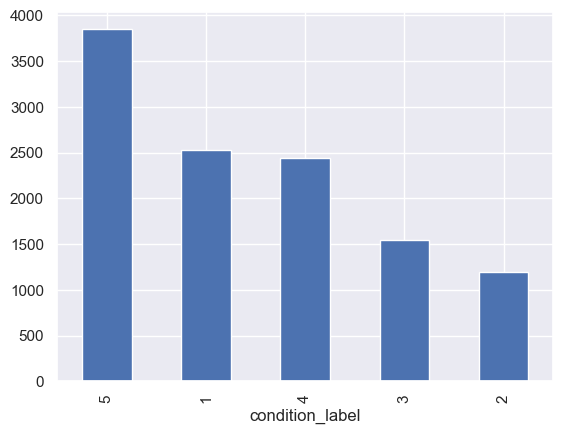

In [4]:
print(dfTrain.head(),'\n',dfTrain.shape)
dfTrain['condition_label'].value_counts().plot.bar()


   condition_label                                   medical_abstract
0                3  Obstructive sleep apnea following topical orop...
1                5  Neutrophil function and pyogenic infections in...
2                5  A phase II study of combined methotrexate and ...
3                1  Flow cytometric DNA analysis of parathyroid tu...
4                4  Paraneoplastic vasculitic neuropathy: a treata... 
 (2888, 2)


<Axes: xlabel='condition_label'>

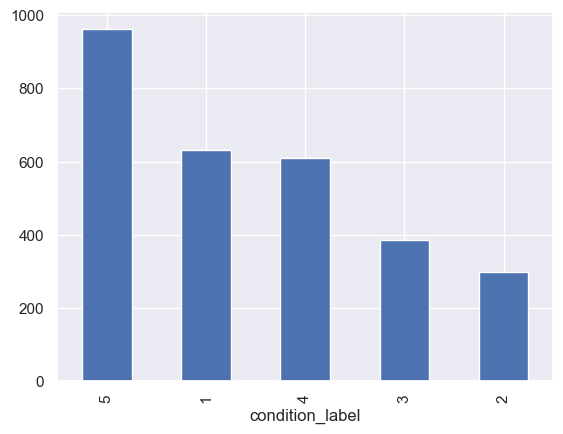

In [5]:
print(dfTest.head(),'\n',dfTest.shape)
dfTest['condition_label'].value_counts().plot.bar()


In [6]:
dfTest['medical_abstract'][101],dfTest['condition_label'][101]

("Genetic diagnosis of Lynch syndrome II in an extended colorectal cancer-prone family. Knowledge of colon cancer genetics, with particular attention to precision in hereditary cancer syndrome diagnosis, can often enable highly targeted surveillance and management strategies for patients at high genetic risk. Unfortunately, the patient's family history of cancer is often given minimal attention, and knowledge of hereditary cancer syndromes is frequently limited. Indeed, many physicians still consider familial adenomatous polyposis (FAP) as the only genetic risk factor for colorectal cancer. This concern with FAP was noted in a colorectal cancer-prone kindred which for decades had been thought to manifest that syndrome. However, after meticulous genetic, medical, and pathologic studies, the cardinal phenotypic characteristics of Lynch syndrome II were observed. The potential for cancer control in current and future generations of families like this one clearly mandates the need for comp

### Data Processing

#### Basic Processing

In [7]:
#Missing Values

print('Training Set: \n',dfTrain.isna().sum(),'Test Set: \n',dfTest.isna().sum(),'Labels: \n',dfLabel.isna().sum())
print( (dfTrain["medical_abstract"] == '').sum(),(dfTest["medical_abstract"] == '').sum(),(dfTrain["condition_label"] == '').sum(),(dfTest["condition_label"] == '').sum() )


Training Set: 
 condition_label     0
medical_abstract    0
dtype: int64 Test Set: 
 condition_label     0
medical_abstract    0
dtype: int64 Labels: 
 condition_label    0
condition_name     0
dtype: int64
0 0 0 0


#### Text processing

In [8]:
def listify(df):
    # simply converts a pandas column into a list for processing.
    return df.tolist()
def dataProcessor(dfList):
    # Performs text processing on a list of text string (medical abstracts) and returns a processed list 
    # for vectorizing for machine learning.
    lemmatizer = WordNetLemmatizer()
    containerDoc=[]
    for i in range(len(dfList)):
        tempDoc=dfList[i]
        tempDoc=tempDoc.lower() # lower case
        tempDoc = tempDoc.split() # split into words
        tempDoc = [word for word in tempDoc if word not in stopwords.words('english')] # remove stops words
        tempDoc = [lemmatizer.lemmatize(word) for word in tempDoc] #Lemmatize
        tempDoc = ' '.join(tempDoc) # recreate the doc
        containerDoc.append(tempDoc)
    return containerDoc
def dataProcessorString(dfString):
    # Performs text processing on a text string (a medical abstract) and returns processed string 
    # for vectorizing for machine learning inference.    
    tempDoc=dfString
    tempDoc=tempDoc.lower() # lower case
    tempDoc = tempDoc.split() # split into words
    tempDoc = [word for word in tempDoc if word not in stopwords.words('english')] # remove stops words
    tempDoc = [lemmatizer.lemmatize(word) for word in tempDoc] #Lemmatize
    tempDoc = ' '.join(tempDoc) # recreate the doc
    return tempDoc

In [9]:
dfListTrain=dataProcessor(dfTrain['medical_abstract'])
dfListTest=dataProcessor(dfTest['medical_abstract'])


#### Vectorize Dataset

In [10]:
def vectorizerFit(dfX,dfY):
    dfX=cVectorize.fit_transform(dfX)
    dfY=dfY.tolist()
    dfY=np.array(dfY)
    return dfX,dfY
x_train_counts,condition_label_list_train=vectorizerFit(dfListTrain,dfTrain['condition_label'])
def vectorizerTransform(dfX,dfY):
    dfX = cVectorize.transform(dfX)
    dfY=dfY.tolist()
    dfY=np.array(dfY)
    return dfX,dfY
x_test_counts,condition_label_list_test=vectorizerTransform(dfListTest,dfTest['condition_label'])

In [11]:
#df = pd.DataFrame(data=cVectorize.transform(dfListTest).todense())
#df

#### TF-IDF

In [12]:
tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)
x_test_tfidf = tfidf_transformer.transform(x_test_counts)


## Modelling

### Model 1 - Naive Bayes

In [13]:
clf = MultinomialNB().fit(x_train_counts, condition_label_list_train)

y_score = clf.predict(x_test_counts)

n_right = 0
for i in range(len(y_score)):
    if y_score[i] == condition_label_list_test[i]:
        n_right += 1

print("Accuracy: %.2f%%" % ((n_right/float(len(condition_label_list_test)) * 100)))


Accuracy: 58.28%


In [14]:
def plot_learning_curve(trainSizes, trainScores, testScores, title="Learning Curve", filePath=None):
    fig, ax = plt.subplots(1,1, figsize=(9, 5))
    trainMeans =  np.mean(trainScores, axis=1)
    testMeans = np.mean(testScores, axis=1)

    ax.plot(trainSizes,trainMeans, color='blue', label='Training Scores')
    ax.plot(trainSizes, testMeans, color='red', label='Validation Scores')

    ax.set_title(title)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Number of examples')
    ax.legend(loc='best')
    if filePath:
        plt.savefig(filePath, bbox_inches='tight' )
#Source https://github.com/ryankresse/plotting_learning_curves/blob/master/learning_curves_code.ipynb

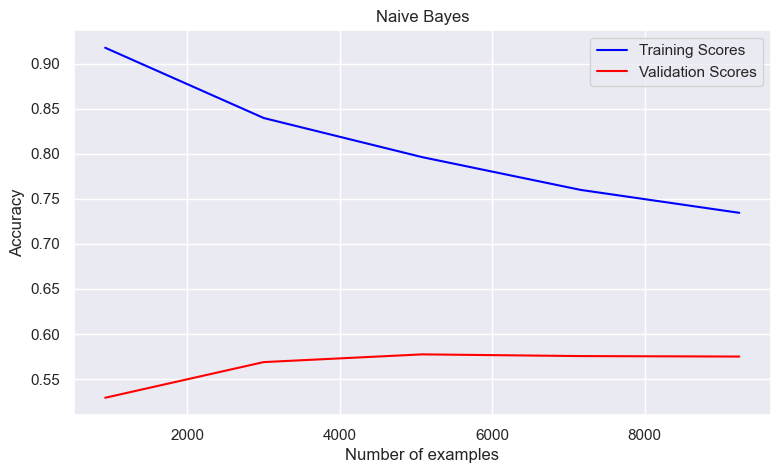

In [15]:
trainSizes, NBTrainScores, NBTestScores = learning_curve(MultinomialNB(), x_train_counts, condition_label_list_train) 
plot_learning_curve(trainSizes, NBTrainScores, NBTestScores, title="Naive Bayes")


### Model 2 - Logistic Regression

In [19]:
LR = LogisticRegression(solver = "saga",penalty='l1')
history = LR.fit(x_train_tfidf,condition_label_list_train)
pred_lr=LR.predict(x_test_tfidf) # Here is where I get an error
n_right=0
for i in range(len(pred_lr)):
    if pred_lr[i] == condition_label_list_test[i]:
        n_right += 1

print("Accuracy: %.2f%%" % ((n_right/float(len(condition_label_list_test)) * 100)))


Accuracy: 59.56%


/Users/aliasgherdalal/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aliasgherdalal/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aliasgherdalal/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aliasgherdalal/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aliasgherdalal/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


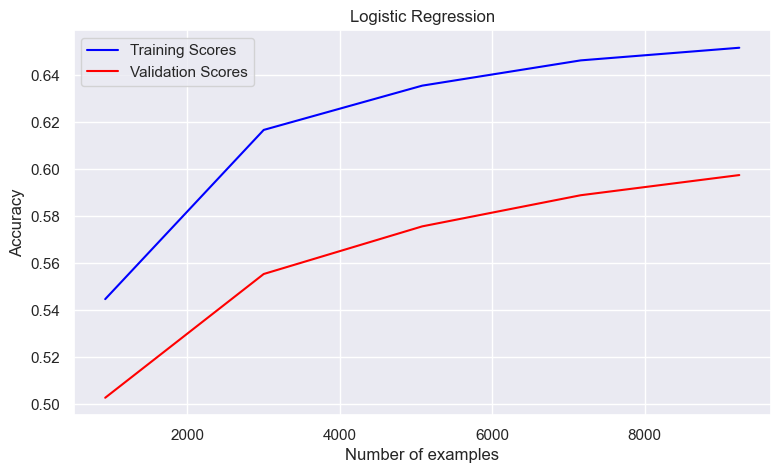

In [20]:
trainSizes, LRTrainScores, LRTestScores = learning_curve(LogisticRegression(solver = "saga", penalty='l1'), x_train_tfidf, condition_label_list_train) 
plot_learning_curve(trainSizes, LRTrainScores, LRTestScores, title="Logistic Regression")


## Model 3 - Deep Learning LSTM

In [ ]:
dXTrain= dfListTrain
dXTest = dfListTest
dYTrain = dfTrain['condition_label'].to_list()
dYTest = dfTest['condition_label'].to_list()

num_classes = len(set(dYTrain)) # number of classes
max_words = 10000 # max number of words in the vocabulary 
max_len = 250 # max length of each text (in terms of number of words)
embedding_dim = 100 # dimension of word embeddings
lstm_units = 64 # number of units in the LSTM layer
epochs = 10
batch_size = 16

# Tokenize the training set
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(dXTrain)
sequences = tokenizer.texts_to_sequences(dXTrain)
dXTrain = pad_sequences(sequences, maxlen=max_len)

# Tokenize the test set
tokenizer.fit_on_texts(dXTest)
sequences= tokenizer.texts_to_sequences(dXTest)
dXTest = pad_sequences(sequences, maxlen=max_len)


dYTrain = [x - 1 for x in dYTrain]
dYTrain=np.array(dYTrain)

dYTest = [x - 1 for x in dYTest]
dYTest=np.array(dYTest)


#### Model 3.1

In [ ]:
modelDL1 = Sequential()
modelDL1.add(Embedding(max_words, embedding_dim, input_length=max_len))
modelDL1.add(SpatialDropout1D(0.2))
modelDL1.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
modelDL1.add(Dense(num_classes, activation='softmax'))
modelDL1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
print(modelDL1.metrics_names)
print(modelDL1.summary())

In [ ]:
modelDL1 = modelDL1.fit(dXTrain, dYTrain, epochs=epochs, batch_size=batch_size,validation_data=(dXTest,dYTest),callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

In [ ]:
plt.title('Loss')
plt.plot(modelDL1.history['loss'], label='train')
plt.plot(modelDL1.history['val_loss'], label='test')
plt.legend()
plt.show();

#### Model 3.2

In [ ]:
modelDL2 = Sequential()
modelDL2.add(Embedding(max_words, embedding_dim, input_length=max_len))
modelDL2.add(LSTM(lstm_units))
modelDL2.add(Dense(num_classes, activation='softmax'))
modelDL2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
print(modelDL2.metrics_names)
print(modelDL2.summary())

In [ ]:
modelDL2 = modelDL2.fit(dXTrain, dYTrain, epochs=epochs, batch_size=batch_size,validation_data=(dXTest,dYTest),callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


In [ ]:
plt.title('Loss')
plt.plot(modelDL2.history['loss'], label='train')
plt.plot(modelDL2.history['val_loss'], label='test')
plt.legend()
plt.show();

## Evaluation

### Model 1 - Naive Bayes

In [21]:
# A confusion matrix of a classification model. 
# Diagonal values represent accurate predictions.

confMatrix = metrics.confusion_matrix(condition_label_list_test, y_score)
print("Confusion matrix\n",confMatrix)

print("Accuracy:",metrics.accuracy_score(condition_label_list_test, y_score))
print("Precision:",metrics.precision_score(condition_label_list_test, y_score,average='weighted'))
print("Recall:",metrics.recall_score(condition_label_list_test, y_score,average='weighted'))


Confusion matrix
 [[488  35  35  16  59]
 [ 39 180   6  10  64]
 [ 31   9 240  33  72]
 [ 13  13  33 464  87]
 [167 141 134 208 311]]
Accuracy: 0.5827562326869806
Precision: 0.5742361475645392
Recall: 0.5827562326869806


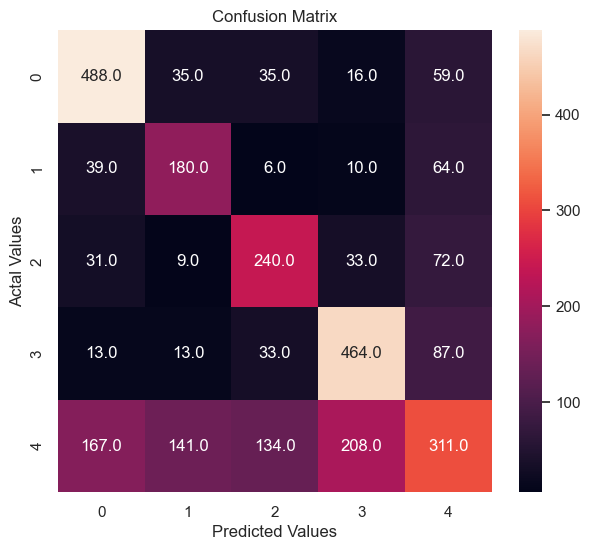

In [22]:
#Plotting confusion matrix
plt.figure(figsize=(7,6))
sns.heatmap((confMatrix), annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()


### Model 2 - Logistic Regression

In [23]:
# A confusion matrix of a classification model. 
# Diagonal values represent accurate predictions.

confMatrix = metrics.confusion_matrix(condition_label_list_test, pred_lr)
print("Confusion matrix\n",confMatrix)

print("Accuracy:",metrics.accuracy_score(condition_label_list_test, pred_lr))
print("Precision:",metrics.precision_score(condition_label_list_test, pred_lr,average='weighted'))
print("Recall:",metrics.recall_score(condition_label_list_test, pred_lr,average='weighted'))


Confusion matrix
 [[445  19  20  14 135]
 [ 25 137   3   7 127]
 [ 30   4 175  22 154]
 [  9   5  21 396 179]
 [115  67  64 148 567]]
Accuracy: 0.5955678670360111
Precision: 0.6047420360400065
Recall: 0.5955678670360111


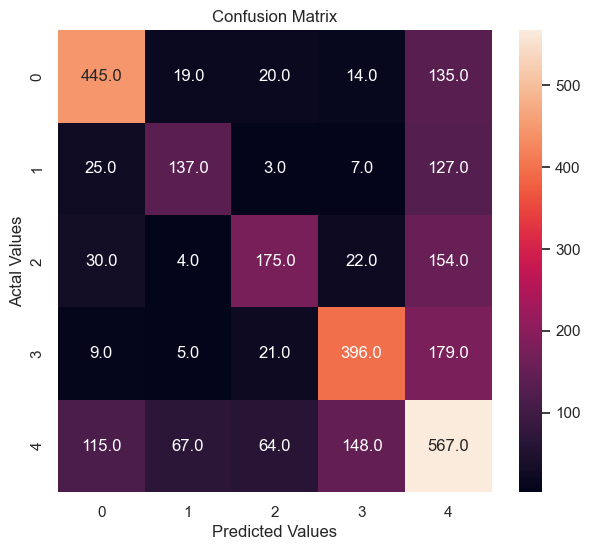

In [24]:
#Plot confusion matrix
plt.figure(figsize=(7,6))
sns.heatmap((confMatrix), annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()


## Save & Loads Models

### Model 1 - Naive Bayes

In [25]:
# SAVE
model_pkl_fileNB = modelPath+"NBTextClass.pkl"  
vec_file = modelPath+"vectorizer.pickle"
pickle.dump(cVectorize, open(vec_file, 'wb'))
with open(model_pkl_fileNB, 'wb') as file:  
    pickle.dump(clf, file)

In [ ]:
# LOAD
with open(model_pkl_fileNB, 'rb') as file:  
    modelUploaded = pickle.load(file)

### Model 2 - Logistic Regression

In [26]:
model_pkl_fileLR = modelPath+"LRTextClass.pkl"  
with open(model_pkl_fileLR, 'wb') as file:  
    pickle.dump(LR, file)

In [ ]:
with open(model_pkl_fileLR, 'rb') as file:  
    modelUploaded = pickle.load(file)

### Model 3 - DL LSTM

#### Model 3.1

In [ ]:
model_pkl_fileDL1 = modelPath+"DL1TextClass.pkl"
with open(model_pkl_fileDL1, 'wb') as file:  
    pickle.dump(modelDL1, file)

#### Model 3.2

In [ ]:
model_pkl_fileDL2 = modelPath+"DL2TextClass.pkl"  
with open(model_pkl_fileDL2, 'wb') as file:  
    pickle.dump(modelDL2, file)

# ****************************************************************************************

## Inference Sample
Source Files: https://github.com/aliadalal/medical_abstract_classification
##### Below shows the image of the application that utilizes the above models Naive Bayes or Logistic Regression to classify medical abstract.

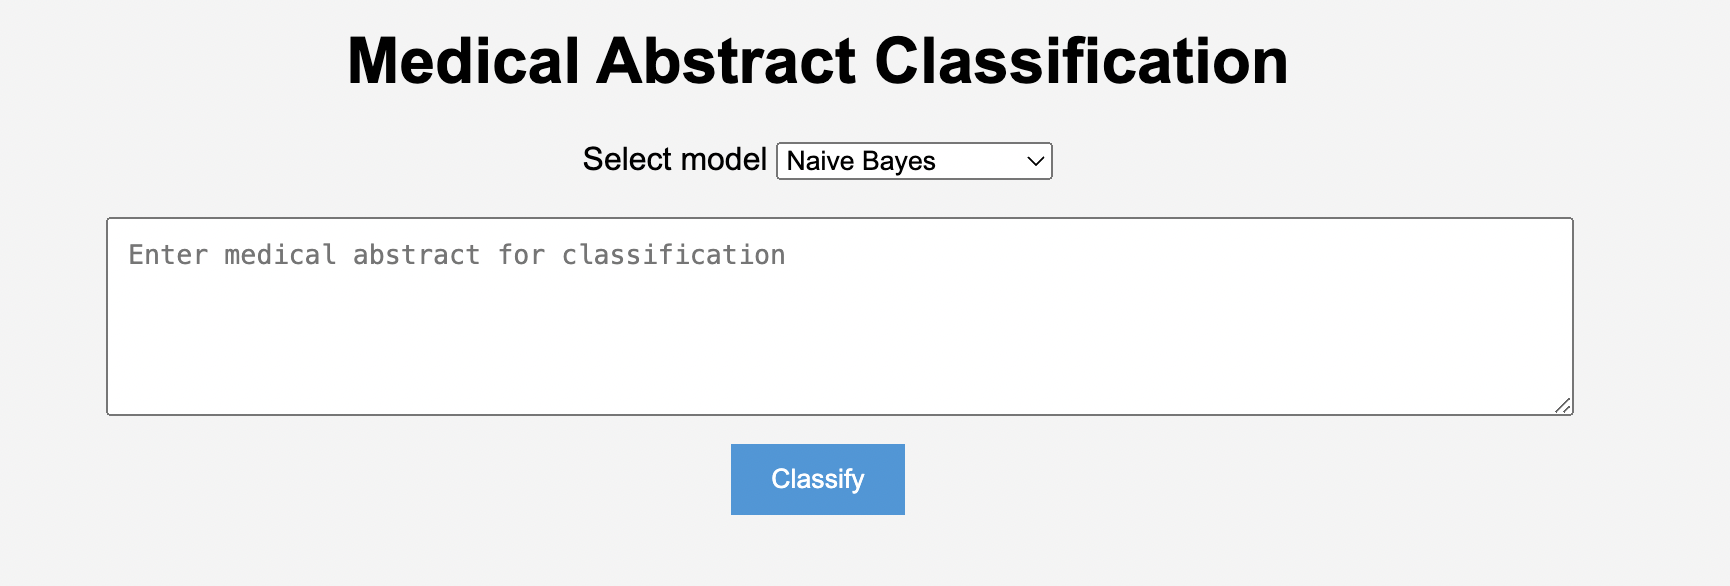
#### Figure 1. The image above is the where a user may select the model for inference and paste the medical abstract.


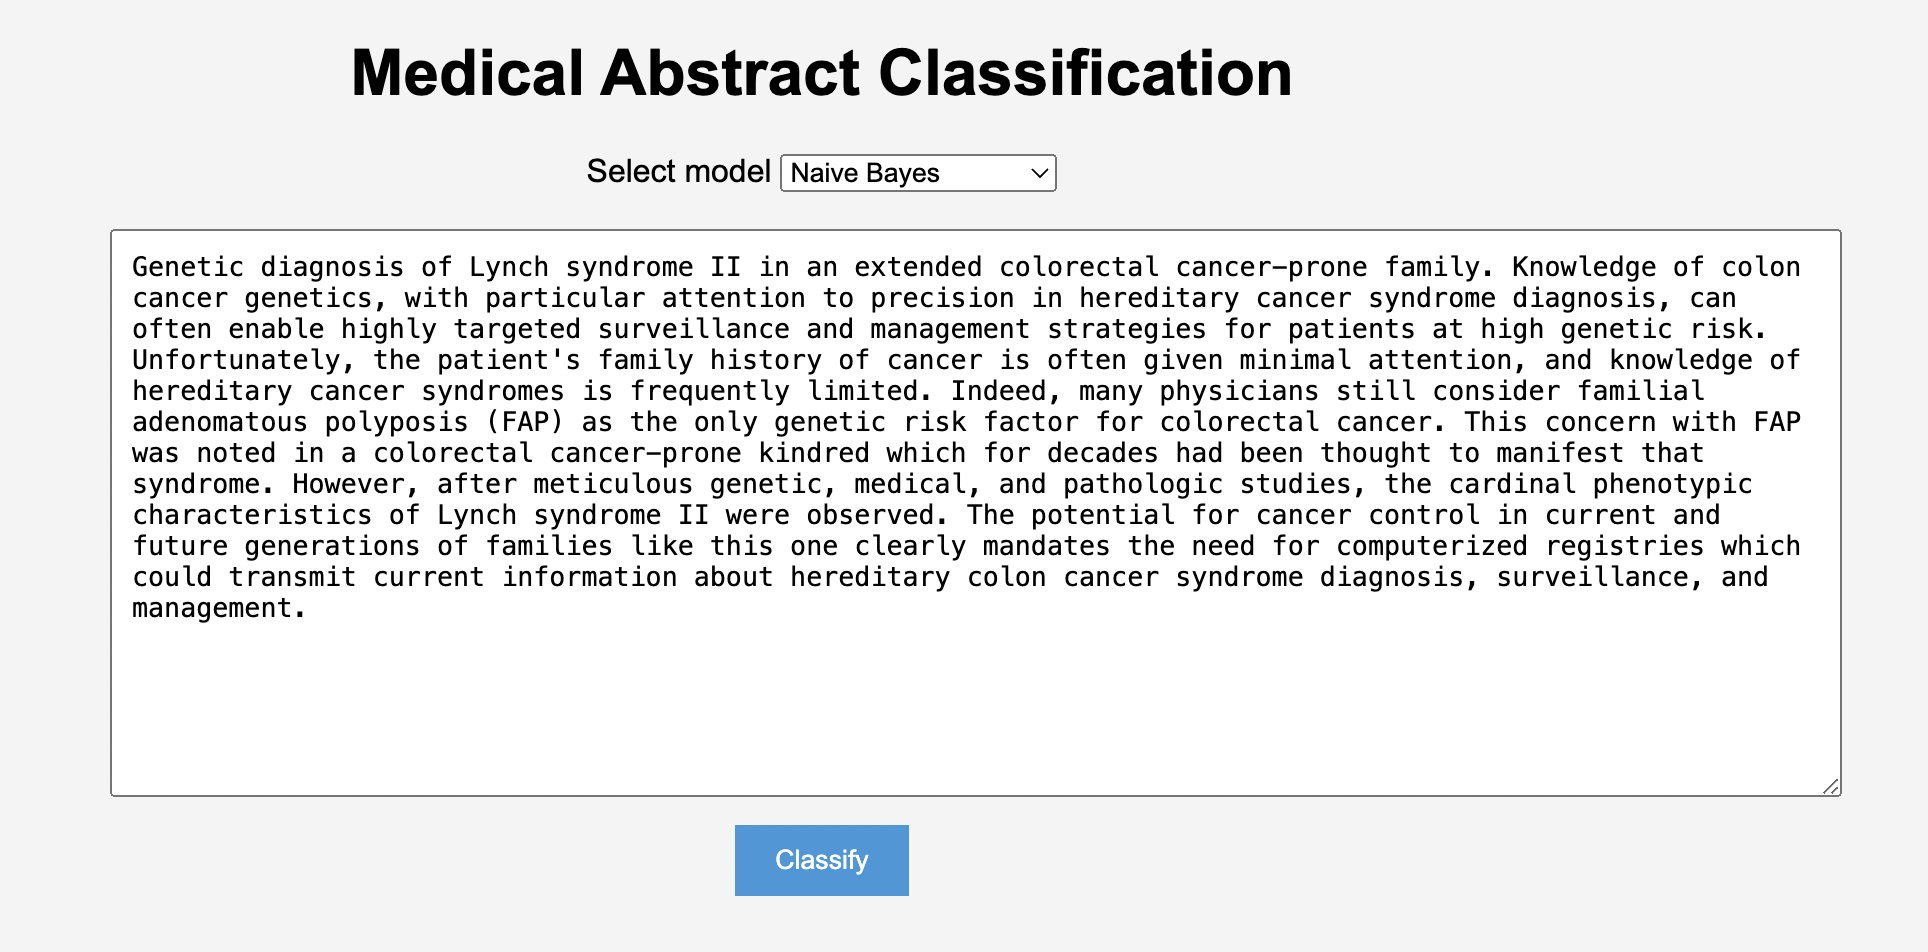
#### Figure 2. The image above is the where a user pastes the medical abstract, Ref: test abstract sample dfTest['medical_abstract'][101],dfTest['condition_label'][101]


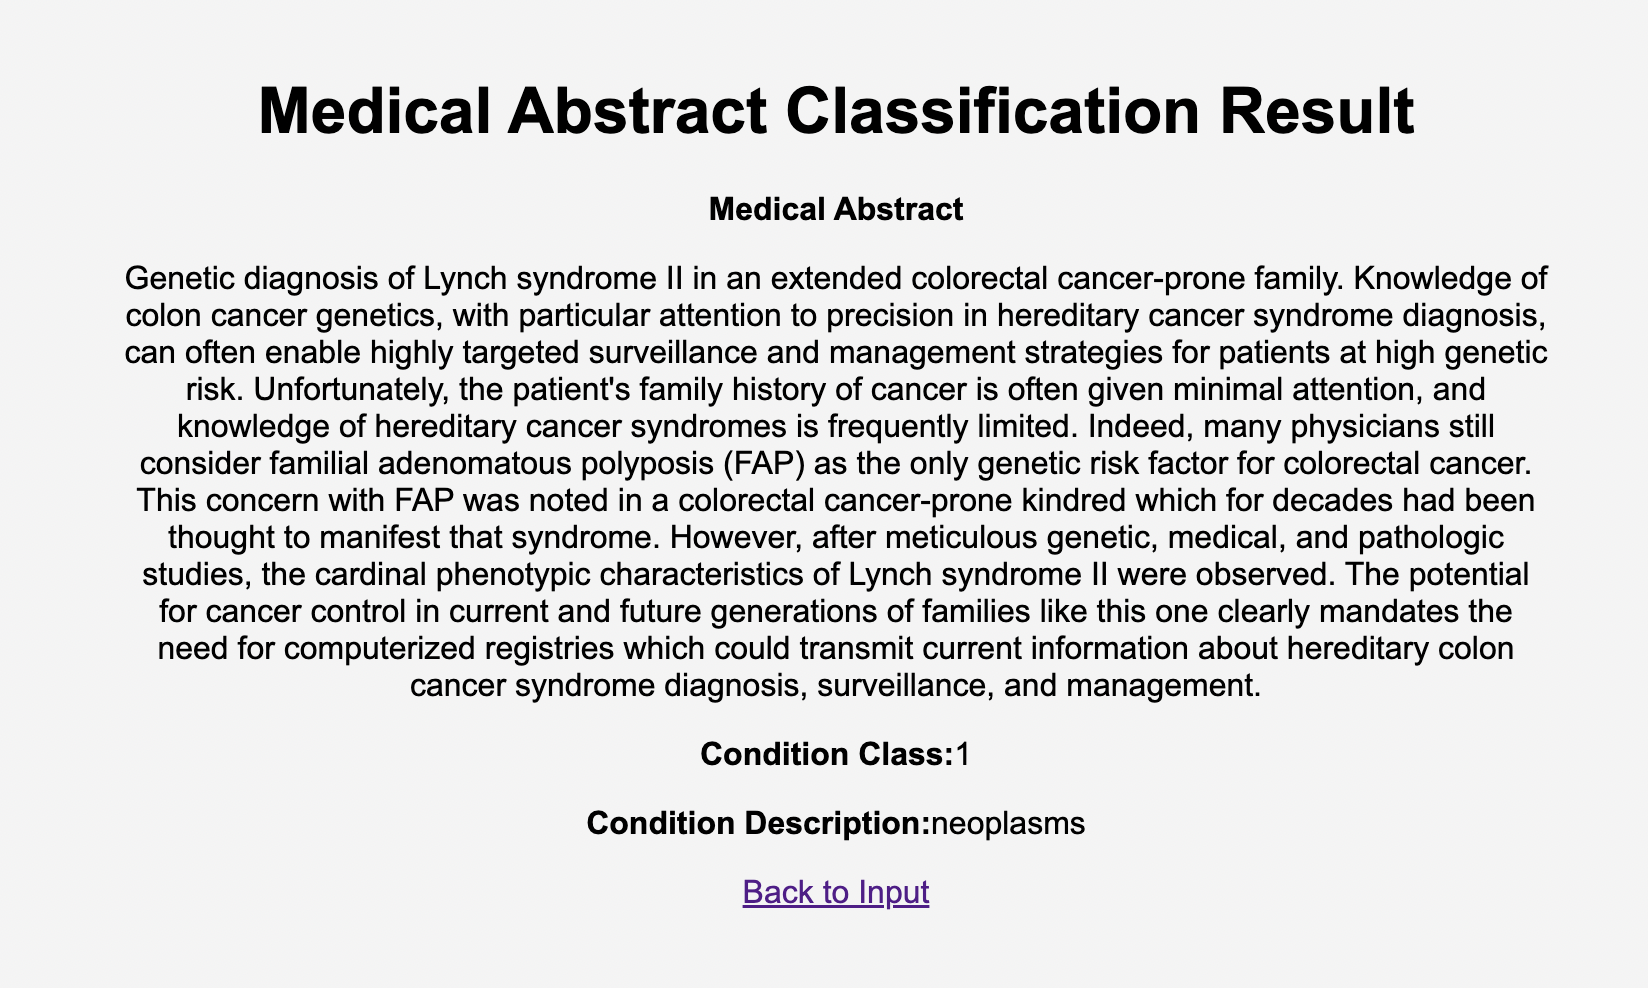
#### Figure 3. The image above shows the response of the inference request using /classify api. Note the api returns the 'Class ID' and 'Class Condition'
